In this notebook we predict the total number of cases for 2023 (not yet officially available). We fit different models to the data between 2002 and 2022: we use the following models from scikit-learn: LinearRegression, KernelRidge, RandomForestRegressor, and DecisionTreeRegressor. We also try fitting polynomials with higher degrees.

In [35]:
#importing packages

%pip install tabula-py
%pip install tueplots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from tueplots import bundles
from tueplots.constants.color import rgb
from tueplots import figsizes, fontsizes, fonts
import math
import scipy.stats

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyparsing>=2.2.1 in c:\users\admin\anaconda3\lib\site-packages (from matplotlib->tueplots) (3.0.4)



Between 2002 and 2013 the datasets were only available in PDF format, so in a preprocessing step we extracted the data to excel files. Also in these years there are fewer features for each offence category, so we read these files separately.

In [36]:
#reading all cases between 2002 and 2013

cases = []
cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Recorded Cases Previous Year', 'Change in number', 'Change in %', 'CR% This Year']

for i in range(2,14):
  if(i<10):
    cases_in_this_year = pd.read_excel(f'Cases200{i}.xlsx', skiprows=0)
  else:
    cases_in_this_year = pd.read_excel(f'Cases20{i}.xlsx', skiprows=0)
  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  to_drop = []
  i = 0
  for ind in cases_in_this_year.index:
    if cases_in_this_year['Key'].isnull()[i] == True:
        to_drop.append(i)
    i += 1
  cases_in_this_year = cases_in_this_year.drop(index=to_drop, axis=0)
  cases_in_this_year = cases_in_this_year.reset_index()
  cases_in_this_year = cases_in_this_year.drop(columns=['index'])

  cases.append(cases_in_this_year)
cases[0]

,Key,Offence,Recorded Cases,Recorded Cases Previous Year,Change in number,Change in %,CR% This Year
0,----,Total offenses,6507394,6363865,143529,2.3,52.6
1,0000,Offenses against life,3541,3577,-36,-1.0,94.5
2,0100,murder (Sect. 211 PC),873,860,13,1.5,96.7
3,0110,robbery attended with murder,64,99,-35,x,95.3
4,0120,sexual murder,27,24,3,x,114.8
...,...,...,...,...,...,...,...
396,8935,economic crime in connection with,14668,13538,1130,8.3,100.3
397,8936,fraud and breach of trust in connection with,16422,36393,-19971,-54.9,99.7
398,8960,offenses against provisions designed to,993,1016,-23,-2.3,91.3
399,8970,computer crime,57488,79283,-21795,-27.5,50.0


In [37]:
#reading cases files between 2014 and 2022

cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Percentage of All Cases', 'Attempts', 'Attempts in %', 'Inhabitants < 20k', '20k < Inhabitants < 100k', '100k < Inhabitants < 500k',
             'Inhabitants > 500k', 'Number of Inhabitants Unknown', 'Threatened with Firearm', 'Shot', 'Clearance', 'Clearance in %', 'Number of Suspects Recorded', 'Male Suspects',
             'Female Suspects', 'Number of Non-German Suspects', 'Non-German Suspects in %']

for i in range(14,23):
  cases_in_this_year = pd.read_excel(f'pks20{i}CasesBasicTable_excel.xlsx', skiprows=7)
  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  cases.append(cases_in_this_year)

We can start analyzing the total case numbers.

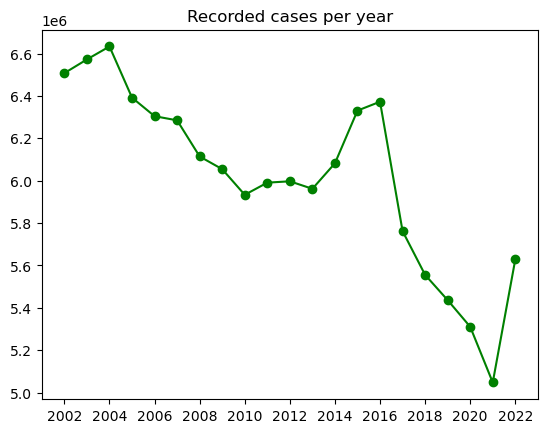

In [38]:
# Plotting the number of recorded cases each year
recorded_cases_per_year = [cases[i].loc[0].at['Recorded Cases'] for i in range(21)]
years = [*range(2002,2023)]
plt.xticks(np.arange(2002,2023,2))
plt.title('Recorded cases per year')
plt.plot(years,recorded_cases_per_year, 'o-', color='green')
plt.show()

How accurately can we predict the total number of recorded cases for the future?

In [39]:
#importing the necessary packages

from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Let's try a simple linear regression:

In [40]:
X = np.array(years).reshape(-1, 1) #[*range(2002,2023)]
y = recorded_cases_per_year
reg = LinearRegression().fit(X, y)
print('Error score: ' + str(reg.score(X, y)))

Error score: 0.7071230908062345


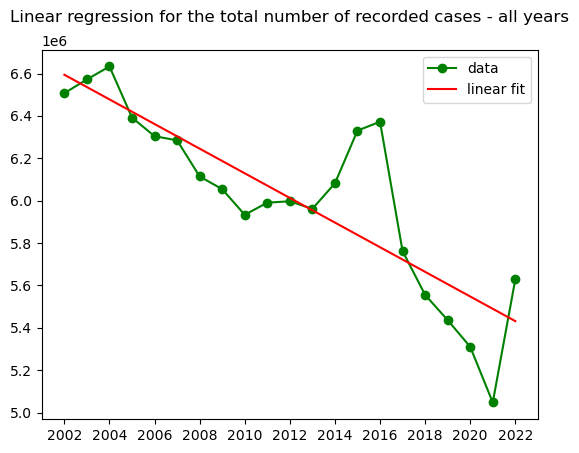

In [41]:
plt.plot(years,recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.plot(X,reg.predict(X), '-', color='red', label = 'linear fit')
plt.xticks(np.arange(2002,2023,2))
plt.title('Linear regression for the total number of recorded cases - all years', pad=20)
plt.legend()
plt.show()

We will try different models. To be able to compare the models we will use four years as test (randomly selected) and compare them based on $R^2$ and $MSE$ scores.

In [42]:
methods = ['Linear Regression', 'Polynomial fitting with degree 2',  'Polynomial fitting with degree 3',
            'Polynomial fitting with degree 4', 'Polynomial fitting with degree 5', 'Polynomial fitting with degree 6',
            'Polynomial fitting with degree 7', 'Polynomial fitting with degree 8', 'Polynomial fitting with degree 9',
            'Polynomial fitting with degree 10', 'Kernel Ridge Regression', 'Decision Tree Regressor', 'Random Forest Regressor']

In [43]:
#We do 10 rounds of model fitting, and choose the one with the least errors in every round

for no in range(10):
  train_years, test_years, train_recorded_cases, test_recorded_cases = train_test_split(
    years, recorded_cases_per_year, train_size=17, test_size=4)

  train_errors_r2 = []
  train_errors_mse = []
  test_errors_r2 = []
  test_errors_mse = []
  prediction_for_2023 = []

  train_years_centered = [i-2012 for i in train_years]
  test_years_centered = [i-2012 for i in test_years]
  years_centered = [i-2012 for i in years]

  X_train = np.array(train_years).reshape(-1, 1)
  X_test = np.array(test_years).reshape(-1, 1)
  X_train_centered = np.array(train_years_centered).reshape(-1, 1)
  X_test_centered = np.array(test_years_centered).reshape(-1, 1)

  #Linear Regression
  reg = LinearRegression().fit(X_train, train_recorded_cases)
  train_errors_r2.append(reg.score(X_train,train_recorded_cases))
  test_errors_r2.append(reg.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, reg.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, reg.predict(X_test)))
  prediction_for_2023.append(reg.predict(np.array(2023).reshape(-1, 1)))

  #Polynomial fitting
  for i in range(2,11):
    prediction = np.polyfit(train_years_centered, train_recorded_cases, i)
    pred_func = np.poly1d(prediction)

    u_train = sum([(i-j)**2 for (i,j) in zip(train_recorded_cases, pred_func(train_years_centered))])
    v_train = sum([(i-sum(train_recorded_cases)/len(train_recorded_cases))**2 for i in train_recorded_cases])
    score_train = 1-u_train/v_train
    u_test = sum([(i-j)**2 for (i,j) in zip(test_recorded_cases, pred_func(test_years_centered))])
    v_test = sum([(i-sum(test_recorded_cases)/len(test_recorded_cases))**2 for i in test_recorded_cases])
    score_test = 1-u_test/v_test
    train_errors_r2.append(score_train)
    test_errors_r2.append(score_test)

    train_errors_mse.append(1/len(train_recorded_cases)*sum([(i-j)**2 for (i,j) in zip(train_recorded_cases,pred_func(train_years_centered))]))
    test_errors_mse.append(1/len(test_recorded_cases)*sum([(i-j)**2 for (i,j) in zip(test_recorded_cases,pred_func(test_years_centered))]))

    prediction_for_2023.append(pred_func(11))


  #KRR
  krr = KernelRidge(alpha = 0.1, kernel = 'poly')
  krr.fit(X_train_centered, train_recorded_cases)
  train_errors_r2.append(krr.score(X_train_centered,train_recorded_cases))
  test_errors_r2.append(krr.score(X_test_centered,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, krr.predict(X_train_centered)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, krr.predict(X_test_centered)))
  prediction_for_2023.append(krr.predict(np.array(11).reshape(-1, 1)))

  #DTR
  dtr = DecisionTreeRegressor(max_depth=4)
  dtr.fit(X_train, train_recorded_cases)
  train_errors_r2.append(dtr.score(X_train,train_recorded_cases))
  test_errors_r2.append(dtr.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, dtr.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, dtr.predict(X_test)))
  prediction_for_2023.append(dtr.predict(np.array(2023).reshape(-1, 1)))

  #RFR
  rfr = RandomForestRegressor(n_estimators=100)
  rfr.fit(X_train, train_recorded_cases)
  train_errors_r2.append(rfr.score(X_train,train_recorded_cases))
  test_errors_r2.append(rfr.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, rfr.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, rfr.predict(X_test)))
  prediction_for_2023.append(rfr.predict(np.array(2023).reshape(-1, 1)))

  best_test_index_r2 = np.argmax(test_errors_r2)
  best_train_index_r2 = np.argmax(train_errors_r2)
  best_test_index_mse = np.argmin(test_errors_mse)
  best_train_index_mse = np.argmin(train_errors_mse)


  print(str(no+1) + ". round: The test years were:")
  print(test_years)
  print("The smallest R^2 test error was produced by the " + methods[best_test_index_r2] +
        " method, the error was: " + str(test_errors_r2[best_test_index_r2].astype(float)))
  print("The smallest R^2 train error was produced by the " + methods[best_train_index_r2] +
        " method, the error was: " + str(train_errors_r2[best_train_index_r2].astype(float)))
  print("The smallest MSE test error was produced by the " + methods[best_test_index_mse] +
        " method, the error was: " + str(test_errors_mse[best_test_index_mse].astype(float)))
  print("The smallest MSE train error was produced by the " + methods[best_train_index_mse] +
        " method, the error was: " + str(train_errors_mse[best_train_index_mse].astype(float)))
  print("The 'best' method predicts " + str(prediction_for_2023[best_test_index_mse].astype(int)) +
        " cases for 2023.\n")


1. round: The test years were:
[2019, 2006, 2017, 2010]
The smallest R^2 test error was produced by the Polynomial fitting with degree 5 method, the error was: 0.9471328015739858
The smallest R^2 train error was produced by the Decision Tree Regressor method, the error was: 0.9938531752611454
The smallest MSE test error was produced by the Polynomial fitting with degree 5 method, the error was: 5177585514.202408
The smallest MSE train error was produced by the Decision Tree Regressor method, the error was: 1145792583.372549
The 'best' method predicts 6250765 cases for 2023.

2. round: The test years were:
[2011, 2015, 2006, 2004]
The smallest R^2 test error was produced by the Polynomial fitting with degree 10 method, the error was: 0.8626678787437294
The smallest R^2 train error was produced by the Decision Tree Regressor method, the error was: 0.9926528831815346
The smallest MSE test error was produced by the Polynomial fitting with degree 10 method, the error was: 7098970925.1584835

We can see that polynomial fitting can frequently achive the best test errors, but it is mainly because the test years are between the minimum and maximum of the training years. However, polynomials will give us irreally high (or low) predictions for the total case number of 2023, so we will not use them for our final prediction.

1. round: The test years were:
[2008, 2009, 2021, 2018, 2003, 2015]
The smallest R^2 test error was produced by the Decision Tree Regressor method, the error was: 0.8589012330726019
The smallest R^2 train error was produced by the Decision Tree Regressor method, the error was: 0.9986831129281464
The smallest MSE test error was produced by the Decision Tree Regressor method, the error was: 36194939729.427086
The smallest MSE train error was produced by the Decision Tree Regressor method, the error was: 184425234.71666667
The 'best' method predicts 5628584 cases for 2023.

2. round: The test years were:
[2022, 2017, 2008, 2013, 2011, 2007]
The smallest R^2 test error was produced by the Linear Regression method, the error was: 0.6555795224536308
The smallest R^2 train error was produced by the Decision Tree Regressor method, the error was: 0.9955828220303863
The smallest MSE test error was produced by the Linear Regression method, the error was: 16021019462.018835
The smallest MSE train 

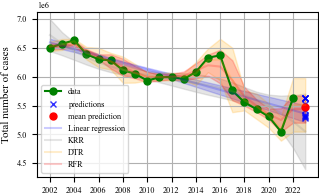

In [45]:
#Fitting models (without polynomials)
#Plotting the results, the mean and std of the different models, and
#determining the mean of the best predictions for 2023 -> this will be our final prediction

methods = ['Linear Regression', 'Kernel Ridge Regression', 'Decision Tree Regressor', 'Random Forest Regressor']
best_predictions = []

#saving the results of the models for every round and year
lr_years = np.zeros((10,22))
krr_years = np.zeros((10,22))
dtr_years = np.zeros((10,22))
rfr_years = np.zeros((10,22))

for no in range(10):
  train_years, test_years, train_recorded_cases, test_recorded_cases = train_test_split(
    years, recorded_cases_per_year, train_size=15, test_size=6)

  train_errors_r2 = []
  test_errors_r2 = []
  train_errors_mse = []
  test_errors_mse = []
  prediction_for_2023 = []

  train_years_centered = [i-2012 for i in train_years]
  test_years_centered = [i-2012 for i in test_years]
  years_centered = [i-2012 for i in years]

  X_train = np.array(train_years).reshape(-1, 1)
  X_test = np.array(test_years).reshape(-1, 1)
  X_train_centered = np.array(train_years_centered).reshape(-1, 1)
  X_test_centered = np.array(test_years_centered).reshape(-1, 1)

  #Linear Regression
  reg = LinearRegression().fit(X_train, train_recorded_cases)
  train_errors_r2.append(reg.score(X_train,train_recorded_cases))
  test_errors_r2.append(reg.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, reg.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, reg.predict(X_test)))
  prediction_for_2023.append(reg.predict(np.array(2023).reshape(-1, 1)))
  for i in range(22):
    lr_years[no,i] = reg.predict(np.array(i+2002).reshape(-1, 1))


  #KRR
  krr = KernelRidge(alpha = 0.1, kernel = 'poly')
  krr.fit(X_train_centered, train_recorded_cases)
  train_errors_r2.append(krr.score(X_train_centered,train_recorded_cases))
  test_errors_r2.append(krr.score(X_test_centered,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, krr.predict(X_train_centered)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, krr.predict(X_test_centered)))
  prediction_for_2023.append(krr.predict(np.array(11).reshape(-1, 1)))
  for i in range(22):
    krr_years[no,i] = krr.predict(np.array(i-10).reshape(-1, 1))

  #DTR
  dtr = DecisionTreeRegressor(max_depth=4)
  dtr.fit(X_train, train_recorded_cases)
  train_errors_r2.append(dtr.score(X_train,train_recorded_cases))
  test_errors_r2.append(dtr.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, dtr.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, dtr.predict(X_test)))
  prediction_for_2023.append(dtr.predict(np.array(2023).reshape(-1, 1)))
  for i in range(22):
    dtr_years[no,i] = dtr.predict(np.array(i+2002).reshape(-1, 1))

  #RFR
  rfr = RandomForestRegressor(n_estimators=100)
  rfr.fit(X_train, train_recorded_cases)
  train_errors_r2.append(rfr.score(X_train,train_recorded_cases))
  test_errors_r2.append(rfr.score(X_test,test_recorded_cases))
  train_errors_mse.append(mean_squared_error(train_recorded_cases, rfr.predict(X_train)))
  test_errors_mse.append(mean_squared_error(test_recorded_cases, rfr.predict(X_test)))
  prediction_for_2023.append(rfr.predict(np.array(2023).reshape(-1, 1)))
  for i in range(22):
    rfr_years[no,i] = rfr.predict(np.array(i+2002).reshape(-1, 1))

  best_test_index_r2 = np.argmax(test_errors_r2)
  best_train_index_r2 = np.argmax(train_errors_r2)
  best_test_index_mse = np.argmin(test_errors_mse)
  best_train_index_mse = np.argmin(train_errors_mse)

  best_predictions.append(prediction_for_2023[best_test_index_mse].astype(int)[0])

  lr_std = np.std(lr_years, axis=0)
  krr_std = np.std(krr_years, axis=0)
  dtr_std = np.std(dtr_years, axis=0)
  rfr_std = np.std(rfr_years, axis=0)
  lr_mean = np.mean(lr_years, axis=0)
  krr_mean = np.mean(krr_years, axis=0)
  dtr_mean = np.mean(dtr_years, axis=0)
  rfr_mean = np.mean(rfr_years, axis=0)


  print(str(no+1) + ". round: The test years were:")
  print(test_years)
  print("The smallest R^2 test error was produced by the " + methods[best_test_index_r2] +
        " method, the error was: " + str(test_errors_r2[best_test_index_r2].astype(float)))
  print("The smallest R^2 train error was produced by the " + methods[best_train_index_r2] +
        " method, the error was: " + str(train_errors_r2[best_train_index_r2].astype(float)))
  print("The smallest MSE test error was produced by the " + methods[best_test_index_mse] +
        " method, the error was: " + str(test_errors_mse[best_test_index_mse].astype(float)))
  print("The smallest MSE train error was produced by the " + methods[best_train_index_mse] +
        " method, the error was: " + str(train_errors_mse[best_train_index_mse].astype(float)))
  print("The 'best' method predicts " + str(prediction_for_2023[best_test_index_mse].astype(int)[0]) +
        " cases for 2023.\n")

print("Based on our methods, we predict " + str(sum(best_predictions)/len(best_predictions)) + " offences for 2023.")


#plotting

plt.plot(years,recorded_cases_per_year, 'o-', color='green', label = 'data', markersize=5)
plt.plot(2023*np.ones(len(best_predictions)),best_predictions, 'x', color='blue', label = 'predictions', markersize=5, alpha=0.8)
plt.plot(2023,sum(best_predictions)/len(best_predictions), 'o', color='red', linewidth = 2, label = 'mean prediction', markersize=5)

plt.plot([*range(2002,2024)],lr_mean, '-', color='blue', alpha = 0.2, label = 'Linear regression')
plt.plot([*range(2002,2024)],krr_mean, '-', color='gray', alpha = 0.2, label = 'KRR')
plt.plot([*range(2002,2024)],dtr_mean, '-', color='orange', alpha = 0.2, label = 'DTR')
plt.plot([*range(2002,2024)],rfr_mean, '-', color='red', alpha = 0.2, label = 'RFR')

plt.fill_between([*range(2002,2024)],lr_mean+2*lr_std, lr_mean-2*lr_std, color='blue', alpha = 0.2)
plt.fill_between([*range(2002,2024)],krr_mean+2*krr_std, krr_mean-2*krr_std, color='gray', alpha = 0.2)
plt.fill_between([*range(2002,2024)],dtr_mean+2*dtr_std, dtr_mean-2*dtr_std, color='orange', alpha = 0.2)
plt.fill_between([*range(2002,2024)],rfr_mean+2*rfr_std, rfr_mean-2*rfr_std, color='red', alpha = 0.2)

plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.rcParams['font.family'] = 'times new roman'
plt.rcParams.update(fontsizes.icml2022())
plt.xticks(np.arange(2002,2024,2))
#plt.title('Predictons by the best models - 10 rounds and their mean')
plt.ylabel('Total number of cases')
plt.legend()
plt.grid()

plt.savefig('prediction_models.pdf')

We now plot the different models separately so we can examine the results.

0.5475791401337458


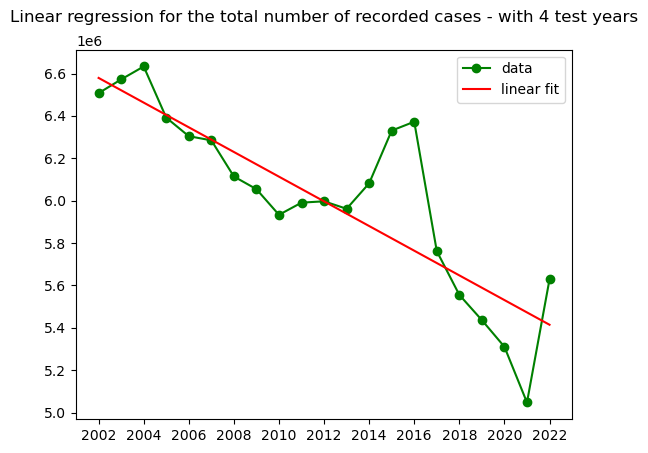

In [46]:
train_years, test_years, train_recorded_cases, test_recorded_cases = train_test_split(
    years, recorded_cases_per_year, train_size=15, test_size=6)

train_errors = []
test_errors = []
prediction_for_2023 = []

train_years_centered = [i-2012 for i in train_years]
test_years_centered = [i-2012 for i in test_years]
years_centered = [i-2012 for i in years]

X_train = np.array(train_years).reshape(-1, 1)
X_test = np.array(test_years).reshape(-1, 1)
X_train_centered = np.array(train_years_centered).reshape(-1, 1)
X_test_centered = np.array(test_years_centered).reshape(-1, 1)

plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

#Linear regression

reg = LinearRegression().fit(X_train, train_recorded_cases)
print(reg.score(np.array(test_years).reshape(-1,1), test_recorded_cases))

plt.rcdefaults()

plt.plot(years,recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.plot(years,reg.predict(np.array(years).reshape(-1,1)), '-', color='red', label = 'linear fit')
plt.xticks(np.arange(2002,2023,2))
plt.title('Linear regression for the total number of recorded cases - with 4 test years', pad=20)
plt.legend()
plt.show()

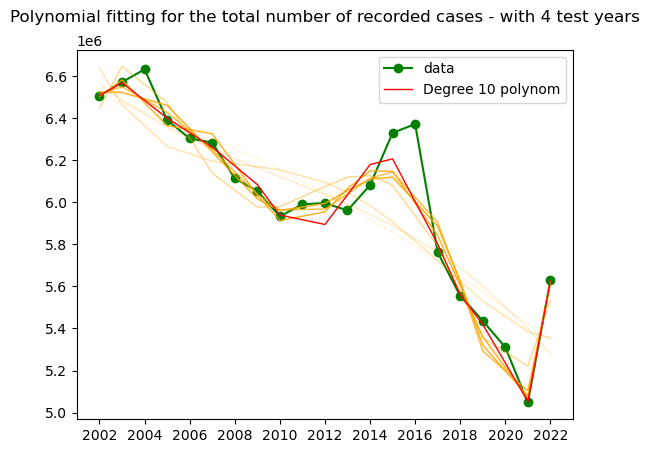

In [47]:
#polynomials

plt.plot(years, recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.xticks(np.arange(2002,2023,2))
plt.title('Polynomial fitting for the total number of recorded cases - with 4 test years', pad=20)
train_years_sorted = sorted(train_years)
train_years_centered_sorted = sorted(train_years_centered)

for i in range(2,11):
  alpha = (i-1)/9;
  prediction = np.polyfit(train_years_centered, train_recorded_cases, i)
  pred_func = np.poly1d(prediction)
  if i==10:
    plt.plot(train_years_sorted,pred_func(train_years_centered_sorted), '-', color='red', alpha = alpha, linewidth = 1, label = 'Degree 10 polynom')
  else:
    plt.plot(train_years_sorted,pred_func(train_years_centered_sorted), '-', color='orange', alpha = alpha, linewidth = 1)


plt.legend()
plt.show()

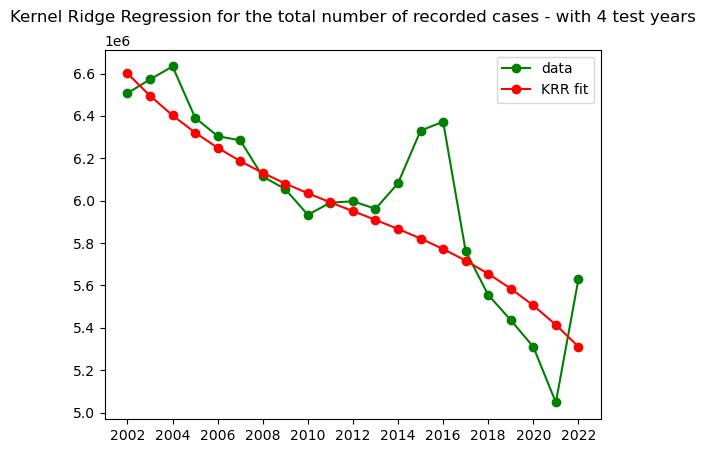

In [48]:
#Kernel ridge regression
krr = KernelRidge(kernel = 'poly', alpha = 0.1)
krr.fit(X_train_centered, train_recorded_cases)

plt.plot(years, recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.plot(years,krr.predict(np.array(years_centered).reshape(-1,1)), 'o-', color='red', label = 'KRR fit')
plt.xticks(np.arange(2002,2023,2))
plt.title('Kernel Ridge Regression for the total number of recorded cases - with 4 test years', pad=20)
plt.legend()
plt.show()

0.9437971770205318


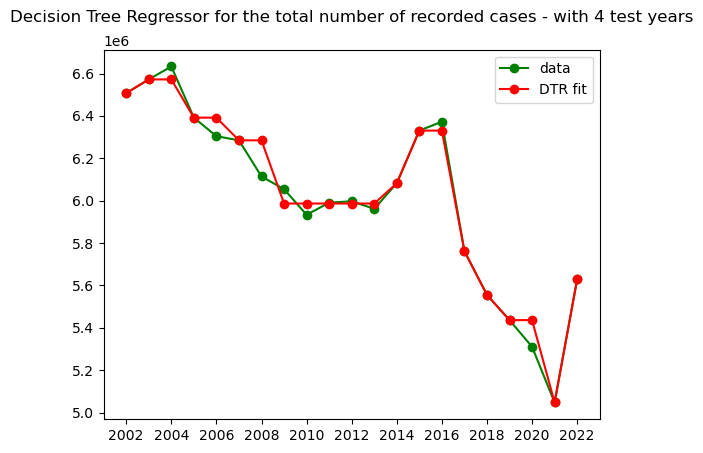

In [49]:
#Decision tree regressor
dtr = DecisionTreeRegressor(max_depth = 4)
dtr.fit(X_train, train_recorded_cases)
print(dtr.score(X_test, test_recorded_cases))

plt.plot(years, recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.plot(years, dtr.predict(np.array(years).reshape(-1,1)), 'o-', color='red', label = 'DTR fit')
plt.xticks(np.arange(2002,2023,2))
plt.title('Decision Tree Regressor for the total number of recorded cases - with 4 test years', pad=20)
plt.legend()
plt.show()

0.9105189107180042


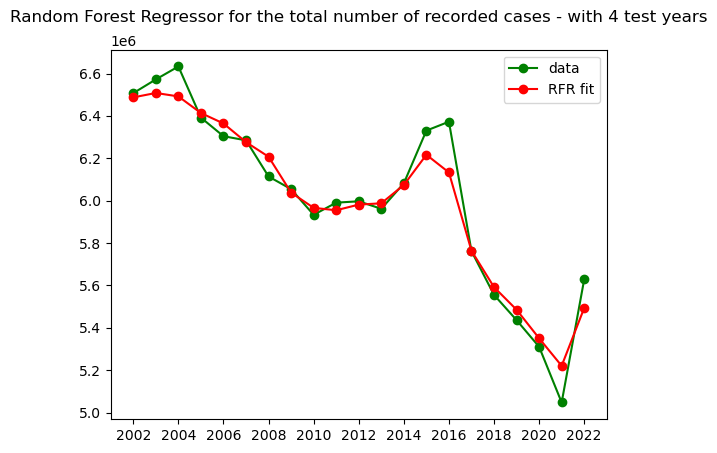

In [50]:
#Random forest regressor

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, train_recorded_cases)
print(rfr.score(np.array(test_years).reshape(-1,1), test_recorded_cases))

plt.plot(years, recorded_cases_per_year, 'o-', color='green', label = 'data')
plt.plot(years,rfr.predict(np.array(years).reshape(-1,1)), 'o-', color='red', label = 'RFR fit')
plt.xticks(np.arange(2002,2023,2))
plt.title('Random Forest Regressor for the total number of recorded cases - with 4 test years', pad=20)
plt.legend()
plt.show()